# Laboratorio 1 — Regresión: predicción de progresión de una enfermedad

Practicarás un flujo completo de regresión con un dataset tabular incluido en scikit-learn.

## Objetivos
- Entrenar un baseline y modelos más potentes.
- Comparar métricas (MAE/RMSE/R2) y detectar sobreajuste.
- Registrar experimentos y justificar decisiones.

## Requisitos
- Laboratorio 0 completado
- scikit-learn


## Contexto

En proyectos reales, rara vez se empieza con una red neuronal. Un buen criterio profesional es:
1) construir un baseline sólido,
2) medir,
3) mejorar con cambios controlados.

Aquí predecimos una variable continua a partir de características numéricas (regresión).


## 1) Cargar datos

Usaremos `load_diabetes`, un dataset clásico para regresión. No requiere descargas externas.


In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_diabetes

data = load_diabetes(as_frame=True)
X = data.data
y = data.target

print("X:", X.shape)
print("y:", y.shape)
X.head()


X: (442, 10)
y: (442,)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


## 2) División train/test y baseline

El baseline más simple es un modelo lineal. La pregunta es: ¿mejora algo si uso un modelo no lineal?


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin = LinearRegression()
lin.fit(X_train, y_train)

y_pred = lin.predict(X_test)

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
metrics_lin = {
    "MAE": mean_absolute_error(y_test, y_pred),
    "RMSE": root_mean_squared_error(y_test, y_pred),
    "R2": r2_score(y_test, y_pred)
}
metrics_lin


{'MAE': 42.79409467959994, 'RMSE': 53.85344583676592, 'R2': 0.4526027629719196}

## 3) Validación cruzada

Una sola partición puede ser engañosa. La validación cruzada estima el rendimiento promedio.


In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

scores = cross_val_score(pipe_ridge, X, y, cv=5, scoring="neg_root_mean_squared_error")
rmse_cv = -scores
print("RMSE CV (media):", rmse_cv.mean())
print("RMSE CV (std):", rmse_cv.std())


RMSE CV (media): 54.69887679033301
RMSE CV (std): 1.2936619332388815


## 4) Modelo no lineal: Random Forest

Los árboles capturan relaciones no lineales y manejan interacciones sin ingeniería manual. 
El riesgo: sobreajuste si no se controla.


In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    max_depth=None
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

metrics_rf = {
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": root_mean_squared_error(y_test, y_pred_rf),
    "R2": r2_score(y_test, y_pred_rf)
}
metrics_rf


{'MAE': 44.47011235955056,
 'RMSE': 54.815794469428305,
 'R2': 0.4328642390894343}

## 5) Interpretabilidad rápida: importancia de variables

En entornos profesionales necesitas explicar *por qué* el modelo predice lo que predice.
Una aproximación inicial es observar importancias (ojo: no es causalidad).


In [7]:
import pandas as pd

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances


bmi    0.338722
s5     0.250250
bp     0.089550
s6     0.067466
s2     0.058956
age    0.058583
s3     0.051521
s1     0.050552
s4     0.024443
sex    0.009957
dtype: float64

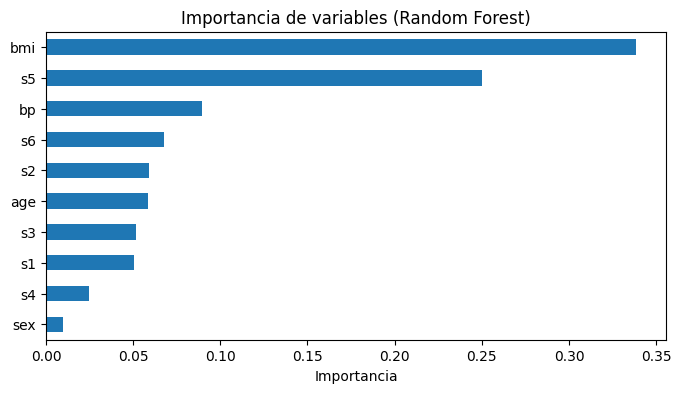

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
importances.head(10).iloc[::-1].plot(kind="barh")
plt.title("Importancia de variables (Random Forest)")
plt.xlabel("Importancia")
plt.show()


## 6) Registro del experimento

Guarda al menos el modelo, hiperparámetros y métricas. 
En producción esto se integra con MLflow/W&B, pero aquí basta con JSON.


In [9]:
from pathlib import Path
import json
from datetime import datetime

def log_experiment_simple(name, config, metrics, out_dir="experimentos"):
    Path(out_dir).mkdir(exist_ok=True)
    path = Path(out_dir) / f"{name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    path.write_text(json.dumps({"config": config, "metrics": metrics}, indent=2))
    return path

p1 = log_experiment_simple("regresion_baseline_lineal", {"model":"LinearRegression"}, metrics_lin)
p2 = log_experiment_simple("regresion_rf", {"model":"RandomForestRegressor","n_estimators":400}, metrics_rf)
p1, p2


(WindowsPath('experimentos/regresion_baseline_lineal_20260121_200448.json'),
 WindowsPath('experimentos/regresion_rf_20260121_200448.json'))

## Ejercicios

### Ejercicio 1: Mejorar el baseline con regularización
Entrena `Ridge` y `Lasso` con varios valores de `alpha`. Compara con validación cruzada y elige el mejor.

**Entregables**
- Tabla comparativa de RMSE medio por alpha
- Conclusión justificando la elección

**Pistas**
- Usa `Pipeline([('scaler', StandardScaler()), ('model', Ridge(...))])`
- Puedes iterar en una lista de alphas

**Criterios de evaluación**
- Comparación reproducible
- Métricas correctamente interpretadas
- Se justifica el trade-off sesgo/varianza

### Ejercicio 2: Diagnóstico de errores
Analiza los residuales del mejor modelo: histograma de errores y gráfico `y_true` vs `y_pred`.

**Entregables**
- 2 gráficos
- Comentario de 5–8 líneas sobre sesgos o patrones

**Criterios de evaluación**
- Gráficos correctos y legibles
- Interpretación con lenguaje técnico (sesgo, heterocedasticidad, etc.)

### Ejercicio 3: Reto avanzado: calibrar hiperparámetros
Usa `RandomizedSearchCV` para optimizar un `RandomForestRegressor` (profundidad, número de árboles, min_samples_leaf).

**Entregables**
- Mejor configuración encontrada
- Métrica CV
- Comparación contra tu mejor baseline

**Criterios de evaluación**
- Búsqueda bien planteada
- No se sobreajusta por fuga de información
- Conclusión basada en CV
